In [27]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/Pokemon.csv")

# Remove Mega evolutions cause theyre to OP
df = df[~df["Name"].str.contains("Mega", na=False)]

# Drop rows with missing values in essential columns
df = df.dropna(subset=["Type 1", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"])

# Convert the Legendary column to a numeric value (True = 1, False = 0)
df["Legendary"] = df["Legendary"].astype(int)

# Show the number of rows and columns in the dataset
print("Dataset shape (rows, columns):", df.shape)

# Display info about columns and datatypes
df.info()

Dataset shape (rows, columns): (751, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 751 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           751 non-null    int64 
 1   Name        751 non-null    object
 2   Type 1      751 non-null    object
 3   Type 2      375 non-null    object
 4   Total       751 non-null    int64 
 5   HP          751 non-null    int64 
 6   Attack      751 non-null    int64 
 7   Defense     751 non-null    int64 
 8   Sp. Atk     751 non-null    int64 
 9   Sp. Def     751 non-null    int64 
 10  Speed       751 non-null    int64 
 11  Generation  751 non-null    int64 
 12  Legendary   751 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 82.1+ KB


In [37]:
import random

matches = []
labels = []

def simulate_battle(p1, p2):
    # Initial HP
    hp1 = p1["HP"]
    hp2 = p2["HP"]

    # Determine who attacks first
    first, second = (p1, p2) if p1["Speed"] >= p2["Speed"] else (p2, p1)
    hp_first = hp1 if first is p1 else hp2
    hp_second = hp2 if second is p2 else hp1

    # Simulate turns
    for _ in range(5):  # max 5 turns
        # First attacks second
        damage = max(1, int((first["Attack"] * 0.6 + first["Sp. Atk"] * 0.4) - (second["Defense"] * 0.5 + second["Sp. Def"] * 0.5)))
        hp_second -= damage
        if hp_second <= 0:
            return 0 if first is p1 else 1

        # Second attacks first
        damage = max(1, int((second["Attack"] * 0.6 + second["Sp. Atk"] * 0.4) - (first["Defense"] * 0.5 + first["Sp. Def"] * 0.5)))
        hp_first -= damage
        if hp_first <= 0:
            return 0 if second is p1 else 1

    # If both survive, pick based on remaining HP
    return 0 if hp1 >= hp2 else 1

# Generate 5000 matches
for _ in range(5000):
    p1 = df.sample(1).iloc[0]
    p2 = df.sample(1).iloc[0]

    stats1 = [p1["HP"], p1["Attack"], p1["Defense"], p1["Sp. Atk"], p1["Sp. Def"], p1["Speed"]]
    stats2 = [p2["HP"], p2["Attack"], p2["Defense"], p2["Sp. Atk"], p2["Sp. Def"], p2["Speed"]]

    matches.append(stats1 + stats2)
    labels.append(simulate_battle(p1, p2))

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert to NumPy arrays
X = np.array(matches)
y = np.array(labels)

# Normalize stats
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

# Create and train the model
model = GradientBoostingClassifier(
    n_estimators=300,       # number of trees
    learning_rate=0.05,     # how fast model learns
    max_depth=4,            # depth of trees
    random_state=42
)
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, n_estimators=300,
                           random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       507
           1       0.94      0.96      0.95       493

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print("\nRandomForest Report:")
print(classification_report(y_test, rf_pred))


RandomForest Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       507
           1       0.92      0.95      0.94       493

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [34]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print(f"Cross-validation accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

Cross-validation accuracy: 0.95 (+/- 0.01)


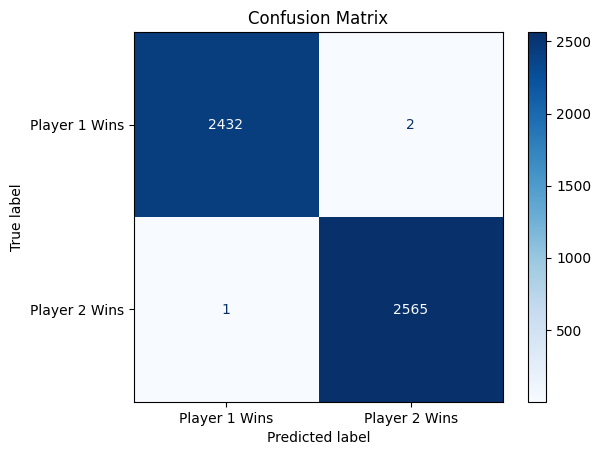

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train final model
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)

# Plot matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Player 1 Wins", "Player 2 Wins"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [36]:
import pickle
import os

os.makedirs("data", exist_ok=True)

with open("data/model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("data/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved.")

Model and scaler saved.
